In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [3]:
!pip install np_utils

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Input, LSTM, concatenate, AveragePooling2D
from tensorflow.keras.layers import Subtract, Conv2D, GlobalMaxPooling2D, Reshape, Conv2DTranspose, UpSampling2D, Embedding
from tensorflow.keras import regularizers
from keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

#tf.enable_eager_execution()

from matplotlib import pyplot as plt

import numpy as np

In [5]:
tf.VERSION

AttributeError: ignored

In [0]:
#parameters
epsilon = 0.01  #the quantity of perturbation we add to the images
step_pgd = 20   #the number of steps taken during the PGD algo
eta = 0.005     #used in PGD algo

# Data

In [7]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


In [0]:
x_train = x_train / 255
x_test = x_test / 255

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Network

In [0]:
# (Conv + ReLU + MaxPool)x3 + AvgPool + FC + ReLU + FC (fully connected)
input = tf.keras.Input(shape=(32, 32, 3))
x = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(input)
x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_last')(x) 

x = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(input)
x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_last')(x)

x = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(input)
x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_last')(x)

x = AveragePooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dense(10, activation='softmax')(x)

adversarial = keras.models.Model(inputs=input, outputs=x)
adversarial.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [49]:
history = adversarial.fit(x_train[:12000, :, :, :], y_train[:12000], batch_size=64, epochs=10, validation_split=0.2)

Train on 9600 samples, validate on 2400 samples
Epoch 1/10
9600/9600 [==============================] - 2s 163us/sample - loss: 1.9532 - accuracy: 0.2937 - val_loss: 1.7429 - val_accuracy: 0.3908
Epoch 2/10
9600/9600 [==============================] - 1s 80us/sample - loss: 1.6520 - accuracy: 0.4147 - val_loss: 1.5936 - val_accuracy: 0.4238
Epoch 3/10
9600/9600 [==============================] - 1s 82us/sample - loss: 1.5293 - accuracy: 0.4667 - val_loss: 1.5273 - val_accuracy: 0.4567
Epoch 4/10
9600/9600 [==============================] - 1s 80us/sample - loss: 1.4252 - accuracy: 0.5025 - val_loss: 1.5027 - val_accuracy: 0.4533
Epoch 5/10
9600/9600 [==============================] - 1s 80us/sample - loss: 1.3608 - accuracy: 0.5217 - val_loss: 1.4171 - val_accuracy: 0.5067
Epoch 6/10
9600/9600 [==============================] - 1s 81us/sample - loss: 1.2987 - accuracy: 0.5437 - val_loss: 1.4318 - val_accuracy: 0.4979
Epoch 7/10
9600/9600 [==============================] - 1s 82us/sampl

In [50]:
print(history.history)
print(type(history.history['acc']))

{'loss': [1.9532384618123373, 1.6519607130686442, 1.5293243972460429, 1.4252407121658326, 1.3608078710238138, 1.2987284326553346, 1.2594412962595622, 1.2177269713083902, 1.1912075622876486, 1.151564400990804], 'accuracy': [0.29375, 0.4146875, 0.46666667, 0.5025, 0.52166665, 0.54375, 0.5601042, 0.5783333, 0.58947915, 0.5991667], 'val_loss': [1.7429246012369792, 1.5935717089970907, 1.5272893714904785, 1.5026642560958863, 1.4171313953399658, 1.4317630815505982, 1.4033182493845622, 1.339562145868937, 1.3297153806686401, 1.2881990909576415], 'val_accuracy': [0.39083335, 0.42375, 0.45666668, 0.45333335, 0.50666666, 0.49791667, 0.50375, 0.5316667, 0.53791666, 0.55333334]}


KeyError: ignored

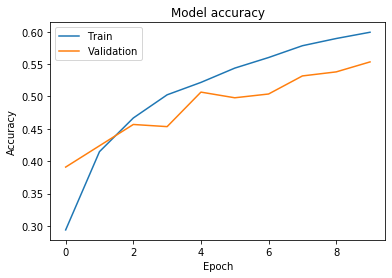

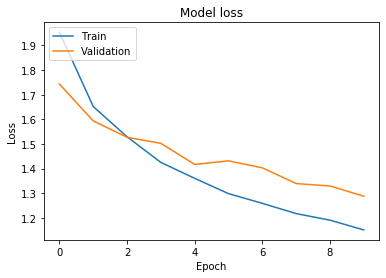

In [51]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Perturbations (FGSM, norme infinie)

In [52]:
#create the perturbations
#the perturbations are on the test set
image = tf.cast(x_test, tf.float32)
    
with tf.GradientTape() as tape:
  tape.watch(image)
  prediction = adversarial(image)
  loss = tf.keras.losses.MSE(y_test, prediction)
    
gradient = tape.gradient(loss, image)
    
perturbations = tf.sign(gradient).numpy()  #ne fonctionne pas sur jupyter notebook
#perturbations = np.asarray(tf.sign(gradient))
print(type(perturbations))
print(perturbations.shape)

x_test_fgsm = x_test + perturbations * epsilon

<class 'numpy.ndarray'>
(10000, 32, 32, 3)


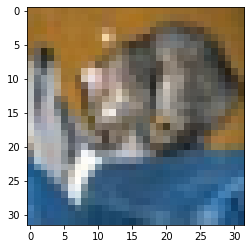

In [0]:
#the original image
plt.imshow(x_test[0].reshape((32, 32, 3)))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


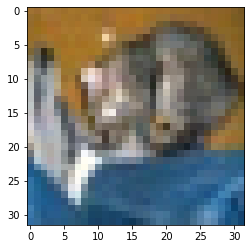

In [0]:
#the modified image (FGSM)
plt.imshow(x_test_fgsm[0].reshape((32, 32, 3)))
plt.show()

In [53]:
#results for the original image
print(adversarial.evaluate(x_test, y_test))

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [54]:
#results for the modified image
print(adversarial.evaluate(x_test_fgsm, y_test))

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

# Perturbations (PGD, norme infinie)

In [0]:
#create the perturbations
x_test_pgd = np.copy(x_test)
image_ref = tf.cast(x_test, tf.float32)
    
for step in range(step_pgd):
  image = tf.cast(x_test_pgd, tf.float32)
  with tf.GradientTape() as tape:
    tape.watch(image)
    prediction = adversarial(image)
    loss = tf.keras.losses.MSE(y_test, prediction)
      
  gradient = tape.gradient(loss, image)
      
  perturbations = tf.sign(gradient).numpy()
  x_test_pgd = x_test_pgd + perturbations * eta
  x_test_pgd = np.maximum(np.minimum(x_test_pgd, x_test + epsilon), x_test - epsilon)

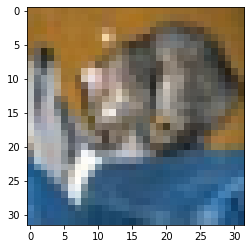

In [0]:
#the original image
plt.imshow(x_test[0].reshape((32, 32, 3)))
plt.show()

In [0]:
#the modified image (PGD)
plt.imshow(x_test_pgd[0].reshape((32, 32, 3)))
plt.show()

In [0]:
#results for the modified image
print(adversarial.evaluate(x_test_pgd, y_test))

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

# Adversarial training

In [0]:
# (Conv + ReLU + MaxPool)x3 + AvgPool + FC + ReLU + FC (fully connected)
input = tf.keras.Input(shape=(32, 32, 3))
x = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(input)
x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_last')(x) 

x = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(input)
x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_last')(x)

x = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(input)
x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_last')(x)

x = AveragePooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dense(10, activation='softmax')(x)

adversarial_trained = keras.models.Model(inputs=input, outputs=x)
adversarial_trained.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
print(x_train.shape)

(50000, 32, 32, 3)


In [43]:
#boucle
epochs = 10
x_train_adv = np.copy(x_train[:12000, :, :, :])
y_train_adv = np.copy(y_train[:12000])
histories = [0 for i in range(epochs)]
#training with the modified training set 
for i in range (epochs):
    histories[i] = adversarial_trained.fit(x_train_adv, y_train_adv, batch_size=64, epochs=1, validation_split=0.2)

    image = tf.cast(x_train_adv, tf.float32)

    with tf.GradientTape() as tape:
      tape.watch(image)
      prediction = adversarial_trained(image)
      loss = tf.keras.losses.MSE(y_train_adv, prediction)

    gradient = tape.gradient(loss, image)
    #tf.enable_eager_execution()
    print(tf.executing_eagerly())
    perturbations = tf.sign(gradient).numpy()
    x_train_adv = x_train_adv + perturbations * epsilon

Train on 9600 samples, validate on 2400 samples
9600/9600 [==============================] - 1s 140us/sample - loss: 2.0425 - accuracy: 0.2654 - val_loss: 1.8520 - val_accuracy: 0.3500
True
Train on 9600 samples, validate on 2400 samples
9600/9600 [==============================] - 1s 79us/sample - loss: 1.9072 - accuracy: 0.2973 - val_loss: 1.8686 - val_accuracy: 0.3158
True
Train on 9600 samples, validate on 2400 samples
9600/9600 [==============================] - 1s 80us/sample - loss: 1.9264 - accuracy: 0.2775 - val_loss: 1.9114 - val_accuracy: 0.3154
True
Train on 9600 samples, validate on 2400 samples
9600/9600 [==============================] - 1s 79us/sample - loss: 1.9767 - accuracy: 0.2526 - val_loss: 1.9719 - val_accuracy: 0.2600
True
Train on 9600 samples, validate on 2400 samples
9600/9600 [==============================] - 1s 80us/sample - loss: 2.0282 - accuracy: 0.2357 - val_loss: 2.0112 - val_accuracy: 0.2629
True
Train on 9600 samples, validate on 2400 samples
9600/9

In [0]:
tf.executing_eagerly()

False

In [0]:
#@title
x = [[2.]]
m = tf.matmul(x, x)
print("hello, {}".format(m))


hello, Tensor("MatMul_21:0", shape=(1, 1), dtype=float32)


In [0]:
acc = [history.history['accuracy'][0] for history in histories]
val_acc = [history.history['val_accuracy'][0] for history in histories]
loss = [history.history['loss'][0] for history in histories]
val_loss = [history.history['val_loss'][0] for history in histories]

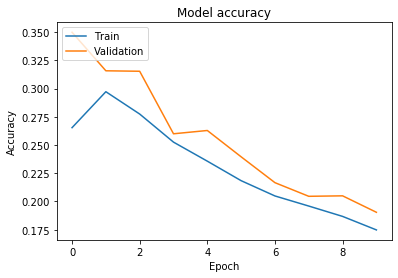

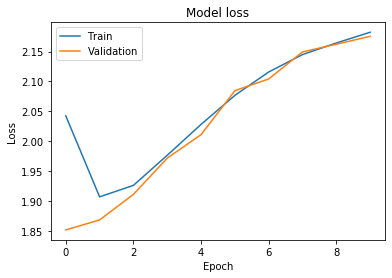

In [45]:
# Plot training & validation accuracy values
plt.plot(acc)
plt.plot(val_acc)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(loss)
plt.plot(val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [46]:
#results for the modified image
print(adversarial_trained.evaluate(x_test, y_test))

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [47]:
#results for the modified image
print(adversarial_trained.evaluate(x_test_fgsm, y_test))

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================